# Research topics - top N articles distribution

In this notebook, we will check the distribution of top N articles of each research topic to see if we can aggregate them together to compare embedding vectors or we have to compare each article to top N articles of each research topic and determine the topic based on k-NN classification. Additionally this tests the quality of our artile embeddings.

### Brief overview

It seems that our top N articles are quite sparse and while we note that some research areas have clearly defined clusters, the distinction between research areas might not be sufficiently clear in some cases. To this purpose, we will adapt article research topic derivation to compare each article to top N articles of each research topic and determine the topic based on k-NN classification. Given that for some research areas we can clearly define clusters, we conclude that our text embeddings are of sufficient quality for further processing.

### Imports & Global Variables

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from box import Box

from util.postgres import create_sqlalchemy_connection, query
from sklearn.manifold import TSNE

In [4]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_connection = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)
# Set the Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

###  Query research topic top N article embeddings

In [16]:
query_str = f"""
SELECT e.article_doi,
       e.article_text_embedding,
       r.research_branch_name,
       r.research_subbranch_name
FROM top_n_research_area_article_text_embedding e
INNER JOIN stg_crossref_top_n_research_area_article a
on a.article_doi = e.article_doi
INNER JOIN dim_research_area r
ON r.research_area_code = a.research_area_code
"""

df = query(conn=pg_connection, query_str=query_str)

df.head(5)

,article_doi,article_text_embedding,research_branch_name,research_subbranch_name
0,10.47989/colis2217,"[0.019426662474870682, 0.027274740859866142, -...",HUMANITIES,Other
1,10.47989/irpaper916,"[0.008925525471568108, 0.009624775499105453, -...",HUMANITIES,Other
2,10.47989/irisic2229,"[0.001625059056095779, 0.034892283380031586, -...",HUMANITIES,Other
3,10.47989/colis2226,"[-0.02814740501344204, 0.02758486196398735, -0...",HUMANITIES,Other
4,10.59350/bct3w-krn98,"[0.017600400373339653, 0.03650189936161041, -0...",HUMANITIES,Other


### T-SNE distribution of embeddings

In [6]:
# Preprocess the data
# Ensure EMBEDDING_TENSOR_DATA is in the correct format, assuming it's a list of strings representing numbers
def parse_embedding(data):
    if isinstance(data, str):
        return np.fromstring(data.strip('[]'), sep=',')
    return data


df['article_text_embedding'] = df['article_text_embedding'].apply(parse_embedding)

# Ensure that all embeddings are of the same length
embedding_lengths = df['article_text_embedding'].apply(len)
if embedding_lengths.nunique() != 1:
    raise ValueError("Embeddings are not of the same length")

# Stack embeddings into a matrix
embeddings_matrix = np.stack(df['article_text_embedding'].values)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings_matrix)

# Add t-SNE results to the dataframe
df['tsne_dim_1'] = tsne_results[:, 0]
df['tsne_dim_2'] = tsne_results[:, 1]

In [7]:
df['group_name'] = df['research_branch_name']
df['subgroup_name'] = df['research_subbranch_name']

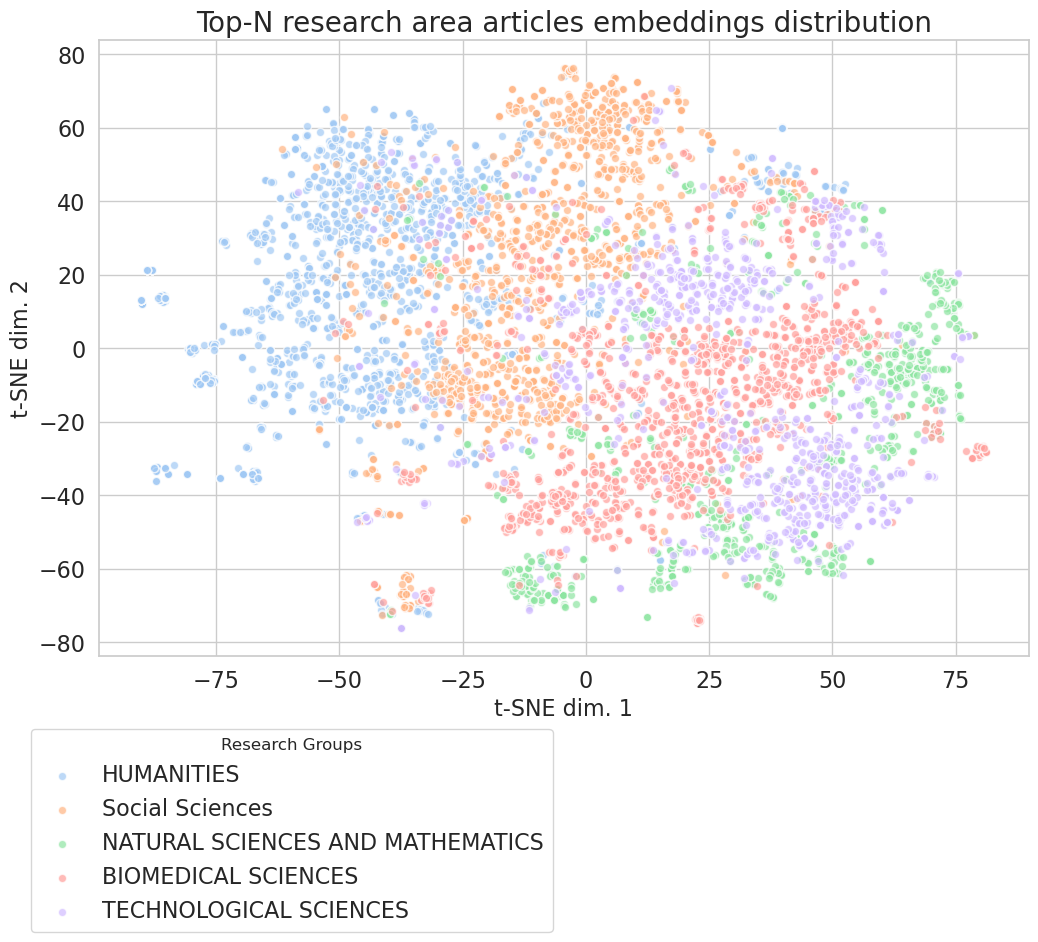

In [8]:

plt.rcParams.update({
    'font.size': 16,  # Global font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 16,  # X and Y label font size
    'xtick.labelsize': 16,  # X tick label font size
    'ytick.labelsize': 16,  # Y tick label font size
    'legend.fontsize': 16,  # Legend font size
    'figure.titlesize': 20  # Figure title font size
})

# Plot the results
plt.figure(figsize=(12, 8))
groups = df['group_name'].unique()

# Plot each group with a unique marker and color
for group in groups:
    subset = df[df['group_name'] == group]
    plt.scatter(
        subset['tsne_dim_1'], subset['tsne_dim_2'],
        label=f'{group}', alpha=0.7, edgecolors='w')

# # Annotating the points
# for i, txt in enumerate(df['research_area_code']):
#     plt.annotate(txt, (df['tsne_dim_1'][i], df['tsne_dim_2'][i]), fontsize=8, alpha=0.6)

# Add legend and labels
plt.legend(title="Research Groups", bbox_to_anchor=(0.5, -0.1))
plt.title('Top-N research area articles embeddings distribution')
plt.xlabel('t-SNE dim. 1')
plt.ylabel('t-SNE dim. 2')
# plt.savefig('../src/assets/report_figures/tsne_top_n_articles.png')
plt.show()

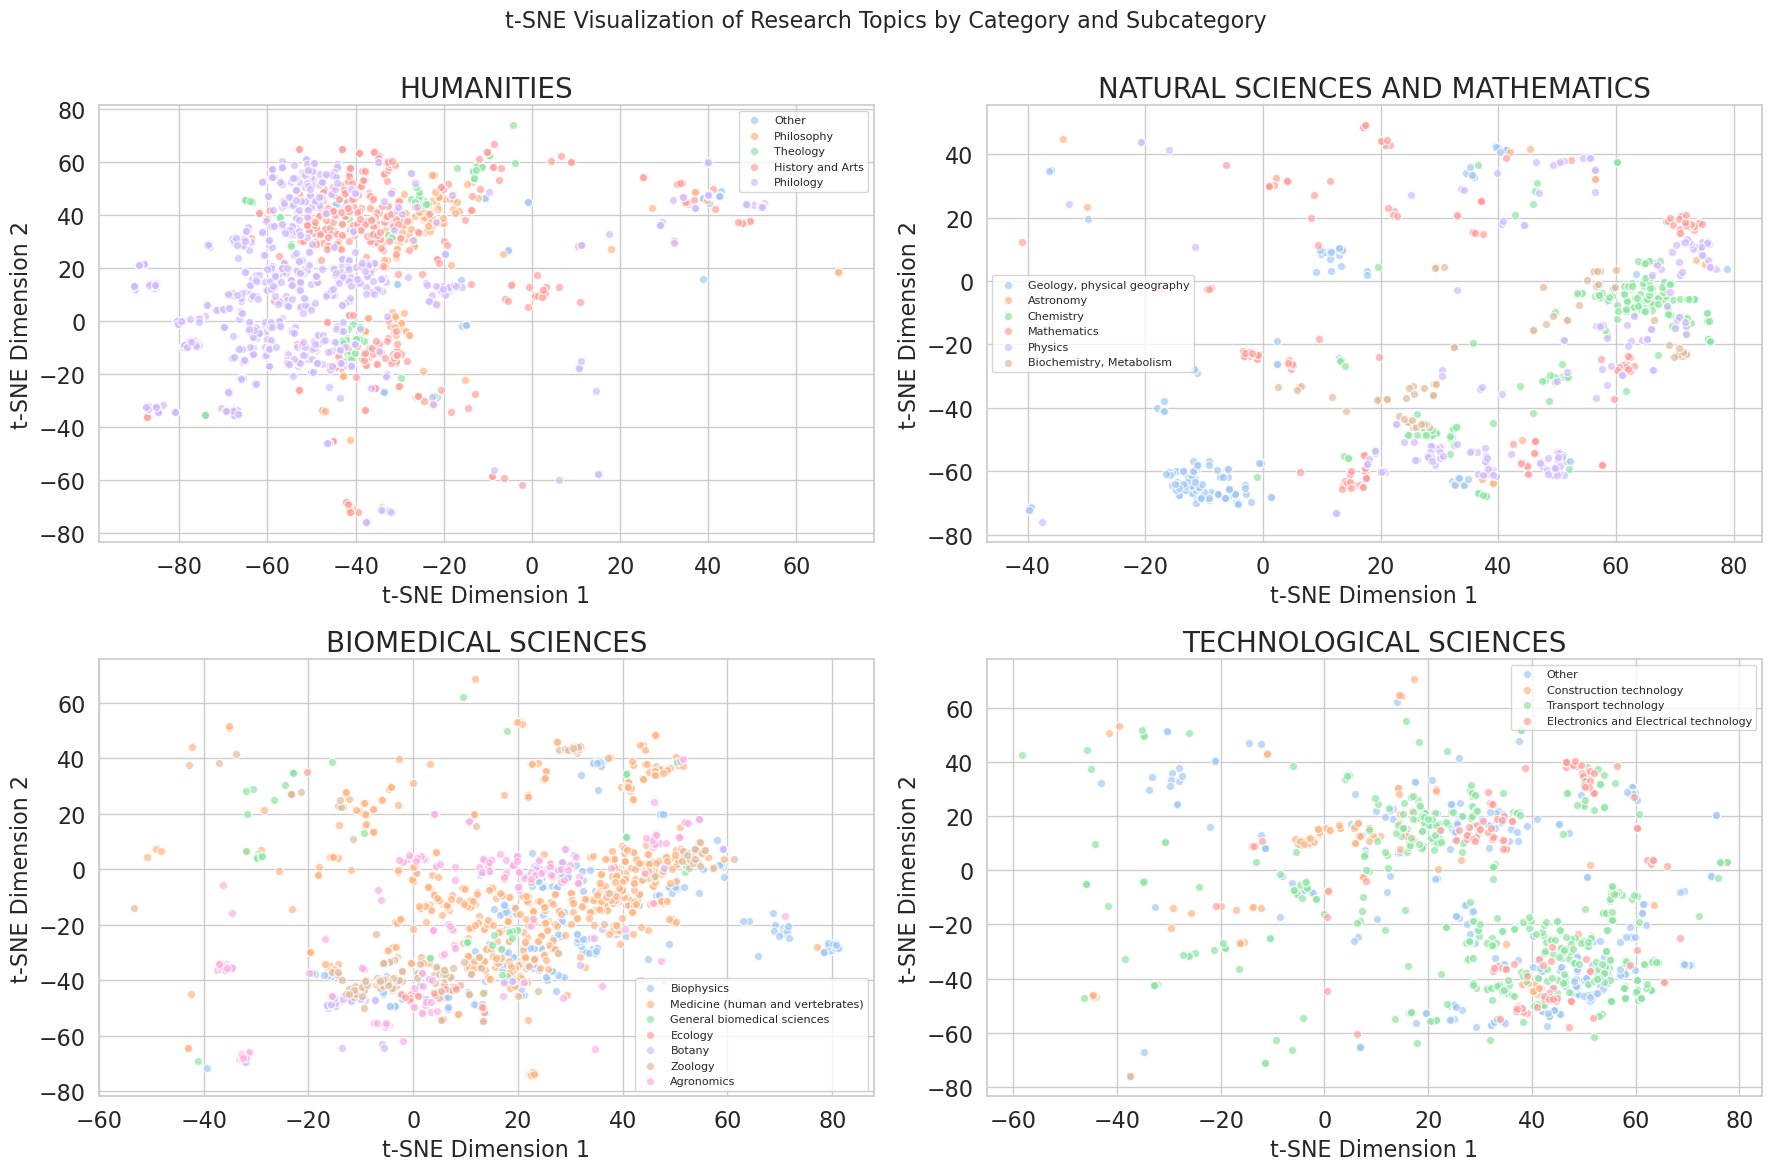

In [15]:

# Set up grid layout for 3x2 plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Filter for each group and plot
top_groups = df['group_name'].unique()
ix = 0
for group in top_groups:
    if group == 'Social Sciences':
        continue
    ax = axes[ix]
    subset = df[df['group_name'] == group]
    for subcategory in subset['subgroup_name'].unique():
        sub_subset = subset[subset['subgroup_name'] == subcategory]
        ax.scatter(
            sub_subset['tsne_dim_1'], sub_subset['tsne_dim_2'],
            label=subcategory, alpha=0.7, edgecolors='w'
        )
    ax.set_title(group.upper())
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.legend(fontsize=8, loc='best')
    ix += 1
# Remove empty subplot if fewer than 6 plots
if len(top_groups) < len(axes):
    for j in range(len(top_groups), len(axes)):
        fig.delaxes(axes[j])

# Add a main title
fig.suptitle("t-SNE Visualization of Research Topics by Category and Subcategory", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust spacing to fit main title
plt.show()